## Data preparation

What is done in this script:

1) Filter by dimension

2) Add percentage_shift

3) Remove NaNs due to percentage_shift

4) Filter only NYSE and NASDAQ tickers

5) Create class1 variable based on uplift in the next quarter

### Supporting information

* Using the ART dimension, see https://www.quandl.com/databases/SF1/documentation?anchor=dimensions

---

As Reported view (AR):

- excludes restatements
- point-in-time view with data time-indexed to the date the form 10 regulatory filing was submitted to the SEC
- presents data for the latest reporting period at that filing date
- may include multiple observations in a quarter if more than one filing is made during the quarter
- on limited occassion may not have any observations in a particular quarter. Sometimes companies are delayed in reporting for up to 18 months. On such occassions they may report multiple -  - documents on the same date to catch up, in which case these datasets will only provide date for the most recent reporting period.
- typically suitable for back-testing

---
* Trailing Twelve Months (T): Quarterly observations of one year duration
* The Date Key represents the SEC filing date for AR dimensions.
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

### Configuration parameters

In [50]:
SF1_FN = "data/raw/SHARADAR_SF1_086134faf658fcc2cdcb53f4295b5fad.csv"
TICKERS_FN = "data/raw/SHARADAR_TICKERS_6cc728d11002ab9cb99aa8654a6b9f4e.csv"

DIMENSION = "ART" # see header

# Minimum percentage change to be considered class 1
MIN_PCT_CHANGE_CLASS1 = 0.3

TRANSFORMED_DATA_FN = "data/transformed/data.csv" # Data
TRANSFORMED_META_FN = "data/transformed/data.json" # Metadata

### Data ingestion

In [10]:
df_sf = pd.read_csv(SF1_FN)

In [11]:
df_sf.columns

Index(['ticker', 'dimension', 'calendardate', 'datekey', 'reportperiod',
       'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc',
       ...
       'sharesbas', 'shareswa', 'shareswadil', 'sps', 'tangibles', 'taxassets',
       'taxexp', 'taxliabilities', 'tbvps', 'workingcapital'],
      dtype='object', length=111)

In [12]:
df_sf['dimension'].unique()

array(['ARQ', 'ART', 'ARY', 'MRQ', 'MRT', 'MRY'], dtype=object)

In [15]:
df_sf_1 = df_sf.loc[df_sf['dimension'] == DIMENSION, :]

In [16]:
df_sf_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108565 entries, 17 to 490760
Columns: 111 entries, ticker to workingcapital
dtypes: float64(105), object(6)
memory usage: 92.8+ MB


In [18]:
# Convert datetimes

for col in ('calendardate', 'datekey', 'reportperiod', 'lastupdated'):
    df_sf_1[col] = pd.to_datetime(df_sf_1[col])

/home/snexus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
df_sf_1.head()

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,...,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital
17,A,ART,2014-03-31,2014-06-04,2014-04-30,2019-08-30,132000000.0,1.102600e+10,1.065700e+10,5.377000e+09,...,333260908.0,333000000.0,337000000.0,20.360,7.134000e+09,0.0,130000000.0,0.0,21.423,3.658000e+09
18,A,ART,2014-06-30,2014-09-02,2014-07-31,2019-08-30,53000000.0,1.038000e+10,1.068250e+10,4.834000e+09,...,333512738.0,334000000.0,338000000.0,20.641,6.610000e+09,0.0,123000000.0,0.0,19.790,3.255000e+09
19,A,ART,2014-09-30,2014-12-22,2014-10-31,2019-08-30,-334000000.0,1.083100e+10,1.071875e+10,5.500000e+09,...,335321802.0,333000000.0,338000000.0,20.964,7.265000e+09,0.0,142000000.0,0.0,21.817,3.798000e+09
20,A,ART,2014-12-31,2015-03-10,2015-01-31,2019-08-30,-261000000.0,7.519000e+09,9.939000e+09,3.654000e+09,...,335810297.0,336000000.0,338000000.0,18.833,4.608000e+09,0.0,157000000.0,0.0,13.714,2.726000e+09
21,A,ART,2015-03-31,2015-06-05,2015-04-30,2019-08-30,-270000000.0,7.412000e+09,9.035500e+09,3.620000e+09,...,333191751.0,334000000.0,337000000.0,16.647,4.555000e+09,0.0,118000000.0,0.0,13.638,2.690000e+09


In [22]:
# Sort by ticker and datekey

df_sf_2 = df_sf_1.sort_values(by=['ticker', 'datekey'])

In [23]:
df_sf_2['price_shifted'] = df_sf_2.groupby('ticker')['price'].shift(-1)
df_sf_2['pct_change_shifted'] = df_sf_2['price_shifted']/df_sf_2['price']-1.0

In [26]:
df_sf_2[['ticker', 'datekey', 'price', 'price_shifted', 'pct_change_shifted']].head(10)

,ticker,datekey,price,price_shifted,pct_change_shifted
17,A,2014-06-04,57.45,58.07,0.010792
18,A,2014-09-02,58.07,41.88,-0.278801
19,A,2014-12-22,41.88,40.63,-0.029847
20,A,2015-03-10,40.63,40.31,-0.007876
21,A,2015-06-05,40.31,35.53,-0.118581
22,A,2015-09-02,35.53,40.83,0.149170
23,A,2015-12-21,40.83,38.09,-0.067108
24,A,2016-03-08,38.09,45.75,0.201103
25,A,2016-06-07,45.75,47.11,0.029727
26,A,2016-09-07,47.11,46.21,-0.019104


### Cleaning and filtering

In [32]:
# Clean NaN rows (last of percentage shift)

df_sf_3 = df_sf_2[~df_sf_2['pct_change_shifted'].isna()]

In [39]:
tickers = pd.read_csv(TICKERS_FN)

In [41]:
valid_tickers = tickers[(tickers['exchange']=='NYSE') | (tickers['exchange']=="NASDAQ")][['ticker','exchange','siccode']]

In [44]:
# Clean only NYSE and NASDAQ

df_sf_4 = valid_tickers.merge(df_sf_3, on='ticker', how='inner')

In [47]:
df_sf_4.loc[:, 'class1'] = 0
df_sf_4.loc[df_sf_4['pct_change_shifted']>MIN_PCT_CHANGE_CLASS1, 'class1'] = 1

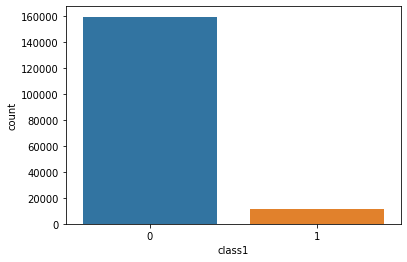

In [49]:
sns.countplot(data=df_sf_4, x='class1');

### Save data

In [58]:
import json
import datetime as dt

In [51]:
df_sf_4.to_csv(TRANSFORMED_DATA_FN, header=True, index=False)

In [52]:
# metadata

feature_cols = [ 
       'eps',
       'revenue', 'currentratio', 'marketcap', 'pe1',  'pe', 'sps', 'ps1', 'evebitda',
       'evebit', 'de', 'pb', 'netmargin', 'ev','divyield','payoutratio','ebitdamargin','grossmargin',
    'publish_month','equityavg','roe','roa','roic','ros','dps','price', 'siccode']

meta_cols = ['ticker', 'pct_change_shifted', 'datekey','marketcap','netmargin','pe1','ev', 'price']

target_col = "class1"

In [63]:
metadata = {
    'features':",".join(feature_cols),
    'meta':",".join(meta_cols),
    "target":target_col,
    'timestamp': dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(TRANSFORMED_META_FN, 'w') as fp:
    json.dump(metadata, fp)